In [38]:
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import pydotplus
from io import StringIO

In [39]:
Data = pd.read_csv("wine.csv")
#增加列名
Data.columns = ["class", "alcohol", "malic acid", "ash", "alcalinity", "magnesium", "phenols", "flavanoids", "noflavanoid", "proanthocyanins", "color intensity", "hue", "diluted wines", "proline"]
print(Data.info())
print(Data.head(5))
n = Data.shape[0]
p = Data.shape[1] - 1
print("数据集样本数为",n)
print("数据集特征数为",p)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            177 non-null    int64  
 1   alcohol          177 non-null    float64
 2   malic acid       177 non-null    float64
 3   ash              177 non-null    float64
 4   alcalinity       177 non-null    float64
 5   magnesium        177 non-null    int64  
 6   phenols          177 non-null    float64
 7   flavanoids       177 non-null    float64
 8   noflavanoid      177 non-null    float64
 9   proanthocyanins  177 non-null    float64
 10  color intensity  177 non-null    float64
 11  hue              177 non-null    float64
 12  diluted wines    177 non-null    float64
 13  proline          177 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.5 KB
None
   class  alcohol  malic acid   ash  alcalinity  magnesium  phenols  \
0      1    13.20        1.78  

{2: 71, 1: 58, 3: 48}


<AxesSubplot:>

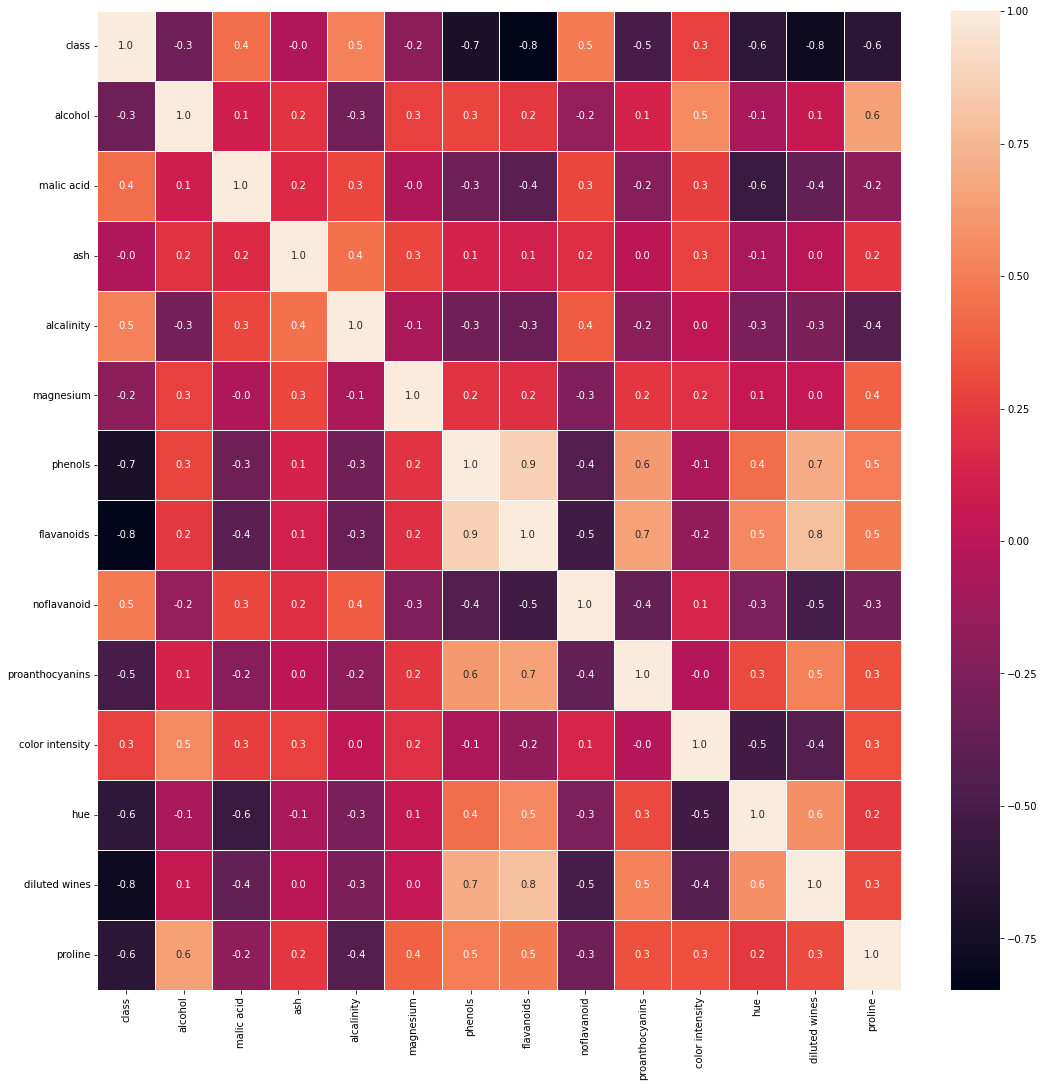

In [40]:
count = dict(Data['class'].value_counts())
print(count)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(Data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [41]:
#PCA降维
X = Data.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.9) #保证降维后的数据保持90%的信息
pca.fit(X)
X = pca.transform(X)
Y = Data['class']
print(X.shape)

(177, 8)


In [42]:
#留出法划分数据集
data = np.column_stack((Data['class'], X))
Data = pd.DataFrame(data = data[0:,0:], columns=['Y','X1','X2','X3','X4','X5','X6','X7','X8'])
n_train = int(n * 0.75) #75%的数据用于训练
n_test = n - n_train
seed = 1425 #学号尾号作为随机种子
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()
Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)
print(Data_train.head())
print(Data_test.head())

     Y        X1        X2        X3        X4        X5        X6        X7  \
0  1.0  2.230243  0.302313 -2.032920 -0.281906 -0.259540 -0.927615  0.079724   
1  1.0  2.531922 -1.062257  0.976724  0.735727 -0.198602  0.557252  0.432350   
2  1.0  3.754677 -2.805309 -0.180370  0.577125 -0.257871  0.100109 -0.364924   
4  1.0  3.049199 -2.170007 -0.638747 -0.487628 -0.631358  0.130817  0.421297   
5  1.0  2.458228 -1.207065 -0.988236 -0.004678 -1.030103 -0.613463  0.066139   

         X8  
0  1.026470  
1 -0.335611  
2  0.646847  
4  0.398731  
5 -0.375278  
      Y        X1        X2        X3        X4        X5        X6        X7  \
3   1.0  1.020131 -0.888380  2.023870 -0.432792  0.275235 -0.403139  0.454721   
8   1.0  2.767971 -0.824521 -0.988956  0.374905 -0.437814  0.144245 -0.869921   
11  1.0  2.128705 -0.710428 -0.880279 -0.288728 -1.217407 -0.210324 -0.219845   
27  1.0  2.203136 -0.722050  1.382059 -0.734933 -0.855532 -0.596719  0.132005   
37  1.0  1.525962  0.737366 -1

In [43]:
#数据预处理
X_train = Data_train.drop(columns = ['Y'],axis = 1)
Y_train = Data_train.Y
X_test = Data_test.drop(columns = ["Y"],axis=1)
Y_test = Data_test.Y
X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True) / np.sqrt(n_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True) / np.sqrt(n_test)
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')


In [44]:
#SVM
params = {'kernel':['linear', 'rbf', 'poly', 'sigmoid'],
          'C': [1e-2, 0.1, 1, 10, 1e2],
          'gamma': ['auto', 0.08, 0.2, 0.4, 0.6, 0.8]}
svm = GridSearchCV(SVC(decision_function_shape='ovr'), params)
svm = svm.fit(X_train_standardized, Y_train)
print('最优超参数组合:', svm.best_params_)
y_pred = svm.predict(X_test_standardized)
num_true = np.sum(y_pred == Y_test)
acc_svm = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('预测结果准确率为：', acc_svm)
print('使用SVM预测数据的分类报告:','\n',
     classification_report(Y_test, y_pred))
#五折交叉验证
scores = cross_val_score(svm, X, Y, cv=5, scoring='accuracy')
print('五折交叉验证结果: ', scores)

最优超参数组合: {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
预测正确的结果数目为： 42
预测错误的结果数目为： 3
预测结果准确率为： 0.9333333333333333
使用SVM预测数据的分类报告: 
               precision    recall  f1-score   support

           1       0.83      1.00      0.91        10
           2       0.94      0.89      0.92        19
           3       1.00      0.94      0.97        16

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45

五折交叉验证结果:  [0.86111111 0.94444444 0.97142857 1.         0.97142857]


In [45]:
#逻辑回归
lr = LogisticRegression().fit(X_train_standardized, Y_train)
y_pred = lr.predict(X_test_standardized)
num_true = np.sum(y_pred == Y_test)
acc_lr = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('预测结果准确率为：', acc_lr)
print('使用逻辑回归预测数据的分类报告:','\n',
     classification_report(Y_test, y_pred))
#五折交叉验证
scores = cross_val_score(lr, X, Y, cv=5, scoring='accuracy')
print(scores)


预测正确的结果数目为： 41
预测错误的结果数目为： 4
预测结果准确率为： 0.9111111111111111
使用逻辑回归预测数据的分类报告: 
               precision    recall  f1-score   support

           1       0.83      1.00      0.91        10
           2       0.90      1.00      0.95        19
           3       1.00      0.75      0.86        16

    accuracy                           0.91        45
   macro avg       0.91      0.92      0.91        45
weighted avg       0.92      0.91      0.91        45

[0.97222222 0.94444444 0.97142857 1.         1.        ]


Iteration: 0, loss: 1.5757
Iteration: 10000, loss: 0.1892
Iteration: 20000, loss: 0.116
Iteration: 30000, loss: 0.0882
Iteration: 40000, loss: 0.0729
Iteration: 50000, loss: 0.063
Iteration: 60000, loss: 0.056
Iteration: 70000, loss: 0.0507
Iteration: 80000, loss: 0.0465
Iteration: 90000, loss: 0.0431


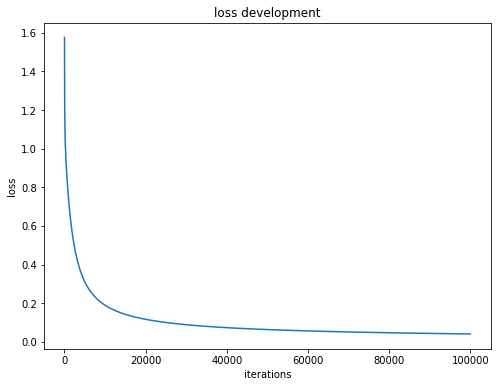

In [46]:
#softmax回归
class SoftmaxRegressor:

    def __init__(self):
        pass

    def train(self, X, Y, n_classes, n_iter, learning_rate):
        self.n_samples, n_features = X.shape
        self.n_classes = n_classes
        self.weights = np.random.rand(self.n_classes, n_features)
        self.bias = np.zeros((1, self.n_classes))
        losses = []
        for i in range(n_iter):
            scores = np.dot(X, self.weights.T) + self.bias
            exp = np.exp(scores)
            sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
            probs = exp / sum_exp
            y_predict = np.argmax(probs, axis=1)[:, np.newaxis]
            y_one_hot = np.zeros((self.n_samples, self.n_classes))
            y_one_hot[np.arange(self.n_samples), Y.T] = 1
            loss = - (1 / self.n_samples) * np.sum(y_one_hot * np.log(probs))
            losses.append(loss)
            dw = (1 / self.n_samples) * np.dot(X.T, (probs - y_one_hot))
            db = (1 / self.n_samples) * np.sum(probs - y_one_hot, axis=0)
            self.weights = self.weights - learning_rate * dw.T
            self.bias = self.bias - learning_rate * db
            if i % 10000 == 0:
                print(f'Iteration: {i}, loss: {np.round(loss, 4)}')

        return self.weights, self.bias, losses

    def predict(self, X):
        scores = np.dot(X, self.weights.T) + self.bias
        exp = np.exp(scores)
        sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
        probs = exp / sum_exp
        return np.argmax(probs, axis=1)[:, np.newaxis]


softmax = SoftmaxRegressor()
w, b, loss = softmax.train(X_train_standardized, Y_train, learning_rate=0.1, n_iter=100000, n_classes=5)
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(100000), loss)
plt.title("loss development")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

In [47]:
tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=3, ccp_alpha=0.0)
tree_model.fit(X_train_standardized, Y_train)
y_pred = tree_model.predict(X_test_standardized)
num_true = np.sum(y_pred == Y_test)
acc_tree = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('预测结果准确率为：', acc_tree)
print('使用决策树预测数据的分类报告:','\n',
     classification_report(Y_test, y_pred))
#五折交叉验证
scores = cross_val_score(tree_model, X, Y, cv=5, scoring='accuracy')
print(scores)
#决策树可视化
dot_data = StringIO()
feature_names = ['X1','X2','X3','X4','X5','X6','X7','X8']
target_names = ['1', '2', '3']
tree.export_graphviz(tree_model, out_file=dot_data, feature_names=feature_names, class_names=target_names, filled=True,  rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("tree.pdf")


预测正确的结果数目为： 40
预测错误的结果数目为： 5
预测结果准确率为： 0.8888888888888888
使用决策树预测数据的分类报告: 
               precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       0.82      0.95      0.88        19
           3       1.00      0.94      0.97        16

    accuracy                           0.89        45
   macro avg       0.90      0.86      0.87        45
weighted avg       0.90      0.89      0.89        45

[0.97222222 0.86111111 0.91428571 0.97142857 0.91428571]


True

In [48]:
#多层感知机
mlp = Pipeline([('scale', StandardScaler()), ('MLPRegressor', MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6, 2), max_iter=5000, random_state=1))])
mlp = mlp.fit(X_train_standardized, Y_train)
y_pred = mlp.predict(X_test_standardized)
print('MSE:', mean_squared_error(y_pred, Y_test))
y_pred = np.around(y_pred)
for i in range(len(y_pred)):
    if y_pred[i] >= 3:
        y_pred[i] = 3
num_true = np.sum(y_pred == Y_test)
acc_mlp = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('MLP预测结果准确率为：', acc_mlp)

MSE: 0.24079317128750138
预测正确的结果数目为： 39
预测错误的结果数目为： 6
MLP预测结果准确率为： 0.8666666666666667


In [49]:
#随机森林
forest = RandomForestRegressor(n_estimators=100, min_samples_split=5, max_depth=10)
forest = forest.fit(X_train_standardized, Y_train)
y_pred = forest.predict(X_test_standardized)
print('MSE:', mean_squared_error(y_pred, Y_test))
y_pred = np.around(y_pred)
num_true = np.sum(y_pred == Y_test)
acc_forest = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('随机森林预测结果准确率为：', acc_forest)
#随机森林可视化
estimators = forest.estimators_
for index, model in enumerate(estimators):
    dot_data = tree.export_graphviz(model , out_file=None,
                         feature_names=['X1','X2','X3','X4','X5','X6','X7','X8'],
                         class_names=['1', '2', '3'],
                         filled=True, rounded=True,
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf("forest.pdf")

MSE: 0.04435367095301084
预测正确的结果数目为： 42
预测错误的结果数目为： 3
随机森林预测结果准确率为： 0.9333333333333333


In [50]:
#集成学习adaboost回归
adaboost = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)
adaboost = adaboost.fit(X_train_standardized, Y_train)
y_pred = adaboost.predict(X_test_standardized)
print('MSE:', mean_squared_error(y_pred, Y_test))
y_pred = np.around(y_pred)
num_true = np.sum(y_pred == Y_test)
acc_adaboost = num_true / Y_test.shape[0]
print('预测正确的结果数目为：', num_true)
print('预测错误的结果数目为：',  Y_test.shape[0] - num_true)
print('adaboost回归预测结果准确率为：', acc_adaboost)

MSE: 0.044459151401758684
预测正确的结果数目为： 43
预测错误的结果数目为： 2
adaboost回归预测结果准确率为： 0.9555555555555556


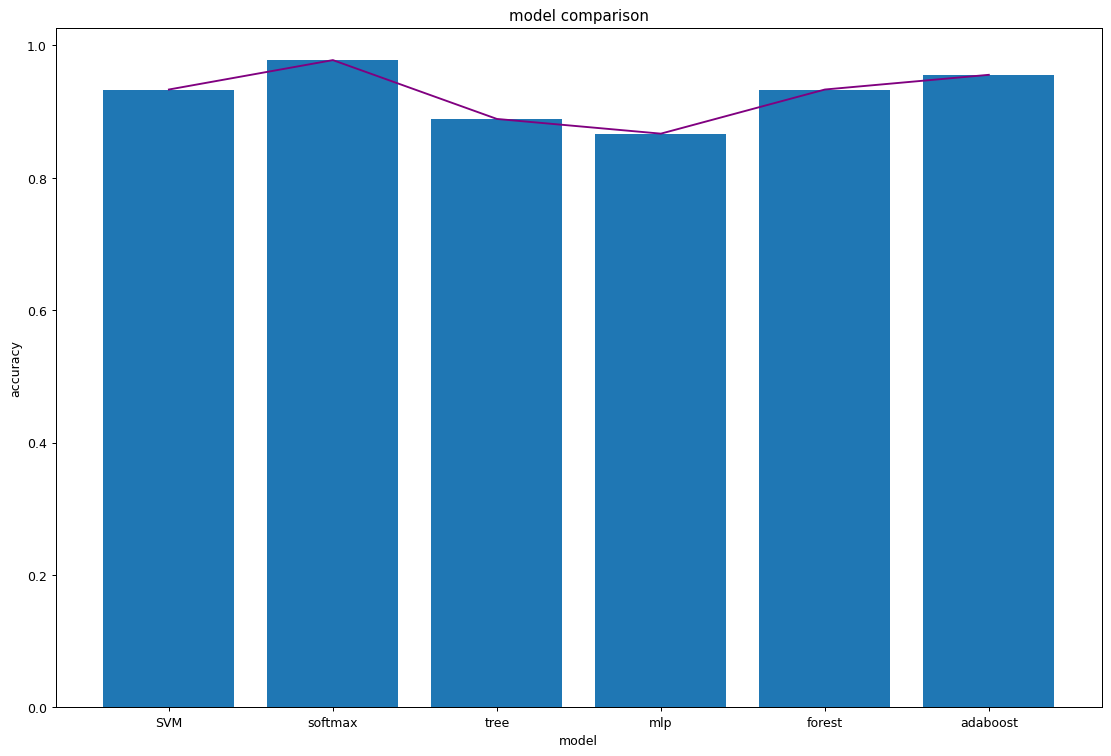

In [51]:
x = ['SVM', 'softmax', 'tree', 'mlp', 'forest', 'adaboost']
y = [acc_svm, acc_softmax, acc_tree, acc_mlp, acc_forest, acc_adaboost]
plt.figure(figsize=(15,10),dpi=90)
plt.bar(x, y)
plt.plot(x, y, c='purple')
plt.xticks(x)
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("model comparison")
plt.show()